In [1]:
# System
import os

# Data processing
import numpy as np
import pandas as pd
import math as m
import datetime as dt

# Results presentation
from tqdm import tqdm_notebook as tqdm
from IPython.display import clear_output
import matplotlib.pyplot as plt

# NN related stuff
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable

from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve

%matplotlib inline

In [2]:
SAVE_INFO = True

In [3]:
if (SAVE_INFO == True):
    DATA_DIR = 'Experiments/'
    EXPERIMENT_DIR = DATA_DIR + 'LSTM_hid2res=5_M=5'
    os.makedirs(EXPERIMENT_DIR)

### посмотрим что мы имеем

## Разбиение датасета по дням и по клеткам в сетке

In [4]:
LEFT_BORDER = 0
RIGHT_BORDER = 2000
DOWN_BORDER = 0
UP_BORDER = 2500

N_CELLS_HOR = 200
N_CELLS_VER = 250

In [5]:
celled_data = torch.load("Data/celled_data_"
                         + str(N_CELLS_HOR)
                         + "x"
                         + str(N_CELLS_VER))
print (celled_data.shape)

torch.Size([9591, 1, 200, 250])


In [6]:
# celled_data_RTL = torch.load("Data/RTL_features")
# print (celled_data_RTL.shape)

In [7]:
def show_one_day_image (tensor, day):
    plt.imshow (tensor[day].squeeze(0), cmap=plt.cm.afmhot_r)
    plt.colorbar()
    
def show_one_day_quakes (tensor, day):
    state = tensor[day].squeeze(0)
    print (state.shape)
    X = []
    Y = []
    M = []
    for i in range(state.shape[0]):
        for j in range(state.shape[1]):
            if (state[i][j] != 0):
                X.append(i)
                Y.append(j)
                M.append(state[i][j].item())
    print (X)
    print (Y)
    print (M)
    
    fig = plt.figure(figsize=(8, 10))
    axes = fig.add_axes([0.1, 0.1, 0.8, 0.8])
    plt.axis([0, state.shape[0], 0, state.shape[1]])
    axes.scatter(X, Y, s=500, c=M, marker='.', cmap=plt.cm.Reds)
#     plt.colorbar()
    

torch.Size([200, 250])
[74, 88, 138, 149]
[89, 87, 169, 177]
[2.5, 2.5999999046325684, 3.700000047683716, 2.9000000953674316]


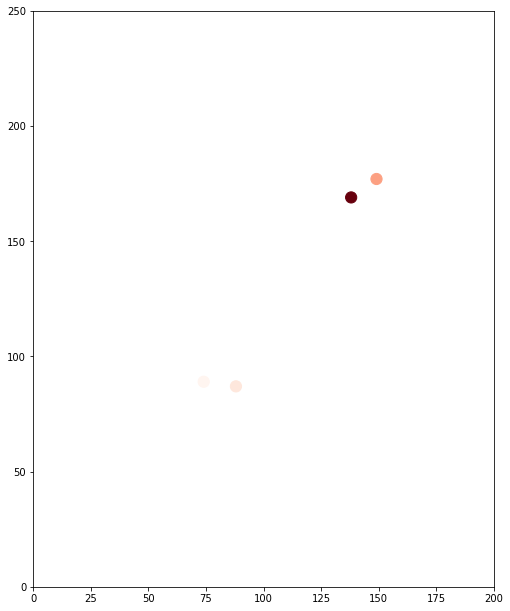

In [8]:
show_one_day_quakes (celled_data, 34)

# Обучение

In [9]:
DEVICE_ID = 2
DEVICE = torch.device('cuda:%d' % DEVICE_ID)
print (DEVICE)
# torch.cuda.set_device(DEVICE_ID)

cuda:2


In [10]:
def my_accuracy (input, target, threshold):
    true = ((input>threshold) == target)
    sum = torch.sum (true.float())
    return sum/input.shape[0]/input.shape[1]/input.shape[2]/input.shape[3]

def my_precision (input, target, threshold):
    TP = torch.sum (((input>threshold) * target      ).float())
    FP = torch.sum (((input>threshold) * (1 - target)).float())
    return TP / (TP + FP)

def my_recall (input, target, threshold):
    TP = torch.sum ((     (input>threshold)  * target).float())
    FN = torch.sum (((1 - (input>threshold)) * target).float())
    return TP / (TP + FN)

def my_precision_recall (input, target, threshold):
    TP = torch.sum ((     (input>threshold)  * target      ).float())
    FP = torch.sum ((     (input>threshold)  * (1 - target)).float())
    FN = torch.sum (((1 - (input>threshold)) * target      ).float())
#     print ('TP = ', TP.item(), 'FP = ', FP.item(), 'FN = ', FN.item(), 'N = ', input.shape[0])
    return TP / (TP + FP), TP / (TP + FN)

def my_precision_TPR_FPR (input, target, threshold):
    TP = torch.sum ((     (input>threshold) .float() * target      ).float())
    FP = torch.sum ((     (input>threshold) .float() * (1 - target)).float())
    FN = torch.sum (((1 - (input>threshold)).float() * target      ).float())
    TN = torch.sum (((1 - (input>threshold)).float() * (1 - target)).float())
    return TP / (TP + FP), TP / (TP + FN), FP / (FP + TN)

def my_TP_FN_FP_TN (input, target, threshold):
    matrix = np.zeros((2, 2))
    matrix[0, 0] = torch.sum ((     (input>threshold) .float() * target      ).float())
    matrix[1, 0] = torch.sum ((     (input>threshold) .float() * (1 - target)).float())
    matrix[0, 1] = torch.sum (((1 - (input>threshold)).float() * target      ).float())
    matrix[1, 1] = torch.sum (((1 - (input>threshold)).float() * (1 - target)).float())
    return matrix / np.sum(matrix)

### Создадим датасет
#### (Может не влезть в оперативку (надо ~ 12Gb))

In [11]:
OBSERVED_DAYS = 64     # ~2 months
DAYS_TO_PREDICT_AFTER  = 10
DAYS_TO_PREDICT_BEFORE = 50
TESTING_DAYS = 1000

HEAVY_QUAKE_THRES = 5

In [12]:
mean_val = (celled_data>HEAVY_QUAKE_THRES).float().mean(dim=0)

torch.Size([1, 200, 250])


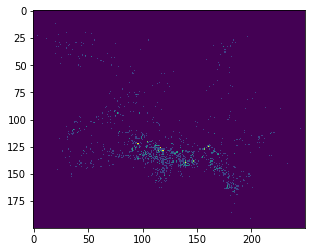

In [13]:
print (mean_val.shape)
plt.imshow(mean_val[0, :, :])

In [14]:
# class EarthquakeDataset_RNN_Usual_Train (Dataset):
#     def __init__(self, celled_data):
#         self.data = celled_data[0:
#                                 (celled_data.shape[0] -
#                                  TESTING_DAYS)]
        
#         self.size = (self.data.shape[0] -
#                      DAYS_TO_PREDICT_BEFORE)
        
#         print ('self.data :', self.data.shape)
#         print ('size      :', self.size)
        
#     def __len__(self):
#         return self.size
    
#     def __getitem__(self, idx):
#         accurate_pred = ((torch.sum(self.data[(idx +
#                                               DAYS_TO_PREDICT_AFTER):
#                                              (idx +
#                                               DAYS_TO_PREDICT_BEFORE)] > HEAVY_QUAKE_THRES,
#                                    dim=0,
#                                    keepdim=True).squeeze(0) > 0).float()
#                          - mean_val)
#         return (self.data[(idx)],
#                 torch.cat([1 - accurate_pred, accurate_pred], dim=0))
        

# class EarthquakeDataset_RNN_Usual_Test (Dataset):
#     def __init__(self, celled_data):
#         self.data = celled_data[(celled_data.shape[0] -
#                                  TESTING_DAYS):
#                                 (celled_data.shape[0])]
#         self.size = (self.data.shape[0] -
#                      DAYS_TO_PREDICT_BEFORE)
        
#         print ('self.data :', self.data.shape)
#         print ('size      :', self.size)
        
#     def __len__(self):
#         return self.size
    
#     def __getitem__(self, idx):
#         return (selsf.data[(idx)],
#                 torch.sum(self.data[(idx +
#                                      DAYS_TO_PREDICT_AFTER):
#                                     (idx +
#                                      DAYS_TO_PREDICT_BEFORE)] > HEAVY_QUAKE_THRES,
#                           dim=0,
#                           keepdim=True).squeeze(0) > 0)

In [15]:
class EarthquakeDataset_RNN_Train (Dataset):
    def __init__(self, celled_data):
        self.data = celled_data[0:
                                (celled_data.shape[0] -
                                 TESTING_DAYS)]
        self.size = (self.data.shape[0] -
                     DAYS_TO_PREDICT_BEFORE)
        
        print ('self.data :', self.data.shape)
        print ('size      :', self.size)
        
    def __len__(self):
        return self.size
    
    def __getitem__(self, idx):
        return (self.data[idx],
                torch.sum(self.data[(idx +
                                     DAYS_TO_PREDICT_AFTER):
                                    (idx +
                                     DAYS_TO_PREDICT_BEFORE)] > HEAVY_QUAKE_THRES,
                          dim=0,
                          keepdim=True).squeeze(0) > 0)
        

class EarthquakeDataset_RNN_Test (Dataset):
    def __init__(self, celled_data):
        self.data = celled_data[(celled_data.shape[0] -
                                 TESTING_DAYS):
                                (celled_data.shape[0])]
        self.size = (self.data.shape[0] -
                     DAYS_TO_PREDICT_BEFORE)
        
        print ('self.data :', self.data.shape)
        print ('size      :', self.size)
        
    def __len__(self):
        return self.size
    
    def __getitem__(self, idx):
        return (self.data[(idx)],
                torch.sum(self.data[(idx +
                                     DAYS_TO_PREDICT_AFTER):
                                    (idx +
                                     DAYS_TO_PREDICT_BEFORE)] > HEAVY_QUAKE_THRES,
                          dim=0,
                          keepdim=True).squeeze(0) > 0)

In [16]:
earthquakes_dataset_train = EarthquakeDataset_RNN_Train (celled_data)
earthquakes_dataset_test  = EarthquakeDataset_RNN_Test  (celled_data)

self.data : torch.Size([8591, 1, 200, 250])
size      : 8541
self.data : torch.Size([1000, 1, 200, 250])
size      : 950


In [17]:
earthquakes_dataloader_train = DataLoader(earthquakes_dataset_train,
                                          batch_size=1,
                                          shuffle=False,
                                          num_workers=1)

earthquakes_dataloader_test  = DataLoader(earthquakes_dataset_test,
                                          batch_size=1,
                                          shuffle=False,
                                          num_workers=1)

### Создадим саму сеть

In [18]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=1):
        super(ConvBlock, self).__init__()
        
        self.CONV  = nn.Conv2d    (in_channels,
                                   out_channels,
                                   kernel_size=kernel_size,
                                   stride=stride,
                                   padding=padding,
                                   bias=False)             # think about it later
        
        self.BNORM =nn.BatchNorm2d(out_channels,
                                   eps=1e-05,
                                   momentum=0.1,
                                   affine=False)
#         self.RELU  = nn.ReLU ()
        
#         self.MAXPOOL = nn.MaxPool2d(3,
#                                     stride=1,
#                                     padding=1,
#                                     dilation=1)
        
    def forward(self, x):
        #print ('sizeof(x) = ', x.size())
        #print ('sizeof(xprev) = ', xprev.size())    
        
        x = self.CONV   (x)
        x = self.BNORM  (x)
#         x = self.RELU   (x)
#         x = self.MAXPOOL(x)
        
        return x

### LSTM
![LSTM](./img/LSTM.png)

In [19]:
class LSTMCell (nn.Module):
    
    def __init__ (self,
                  mean_val,
                  embedding_size=16,
                  hidden_state_size=32,
                  reverse_log_bias=0,
                  device=torch.device('cpu')):
        super(self.__class__,self).__init__()
        
        self.emb_size = embedding_size
        self.hid_size = hidden_state_size
        
        self.mean_val = mean_val.to(device)
        self.prior = torch.log(torch.cat([1-mean_val, mean_val], dim=0)).to(device).unsqueeze(0)
        self.prior = self.prior + reverse_log_bias
        
#         self.embedding = ConvBlock (1, self.emb_size, kernel_size=3)
        self.embedding = nn.Sequential(ConvBlock(1,
                                                 self.emb_size,
                                                 3),
                                       nn.ReLU(),
                                       ConvBlock(self.emb_size,
                                                 self.emb_size,
                                                 3))
        self.hidden_to_result = nn.Sequential (ConvBlock(hidden_state_size, 
                                                         hidden_state_size, 
                                                         kernel_size=3),
                                               nn.ReLU(),
                                               ConvBlock(hidden_state_size, 
                                                         hidden_state_size, 
                                                         kernel_size=3),
                                               nn.ReLU(),
                                               ConvBlock(hidden_state_size, 
                                                         hidden_state_size, 
                                                         kernel_size=3),
                                               nn.ReLU(),
                                               ConvBlock(hidden_state_size, 
                                                         hidden_state_size, 
                                                         kernel_size=3),
                                               nn.ReLU(),
                                               ConvBlock(hidden_state_size, 
                                                         2, 
                                                         kernel_size=3)
                                               )
        
        self.out_activation = nn.Softmax (dim=1)
        
        self.f_t = nn.Sequential (ConvBlock(self.hid_size + self.emb_size,
                                            self.hid_size,
                                            3),
                                  nn.Sigmoid())
        self.i_t = nn.Sequential (ConvBlock(self.hid_size + self.emb_size,
                                            self.hid_size,
                                            3),
                                  nn.Sigmoid())
        self.c_t = nn.Sequential (ConvBlock(self.hid_size + self.emb_size,
                                            self.hid_size,
                                            3),
                                  nn.Tanh())
        self.o_t = nn.Sequential (ConvBlock(self.hid_size + self.emb_size,
                                            self.hid_size,
                                            3),
                                  nn.Sigmoid())
        
    def forward (self, x, prev_state):
        (prev_c, prev_h) = prev_state
        x_emb = self.embedding(x)
        
        x_and_h = torch.cat([prev_h, x_emb], dim=1)
        
        f_i = self.f_t(x_and_h)
        i_i = self.i_t(x_and_h)
        c_i = self.c_t(x_and_h)
        o_i = self.o_t(x_and_h)
        
        next_c = prev_c * f_i + i_i * c_i
        next_h = torch.tanh(next_c) * o_i
        
        assert prev_h.shape == next_h.shape
        assert prev_c.shape == next_c.shape
        
        out = self.hidden_to_result(next_h)
        
        return (next_c, next_h), self.out_activation(self.prior + out)
        
    def init_state (self, batch_size, device=torch.device("cpu")):
        return (Variable(torch.zeros(batch_size,
                                     self.hid_size,
                                     N_CELLS_HOR,
                                     N_CELLS_VER,
                                     device=device)),
                Variable(torch.zeros(batch_size,
                                     self.hid_size,
                                     N_CELLS_HOR,
                                     N_CELLS_VER,
                                     device=device)))
               
    

#### Функция тренеровки

In [20]:
def my_crossEntropy(weights, prediction, target):
    assert len(weights) == prediction.shape[1]
    assert prediction.shape == target.shape
    loss = 0
    for i in range(prediction.shape[0]):
        for j in range(len(weights)):
            loss -= weights[j] * torch.sum(target[i, j] * prediction[i, j].log())
    return loss / prediction.shape[2] / prediction.shape[3]

In [21]:
def train_network_RNN (RNN_cell,
                       device,
                       dataloader_train,
                       n_cycles=1,
                       learning_rate=0.0003,
                       earthquake_weight=1.,
                       lr_decay=1.):
    
    loss_massive = []
    i = 0
    
    RNN_cell.to(device)
    
    weights = torch.tensor([1., earthquake_weight], dtype=torch.float).to(device)
    criterion = nn.CrossEntropyLoss(weights)
    
    i = 0
    for cycle in range(n_cycles):
        
        optimizer = torch.optim.Adam(RNN_cell.parameters(), lr=learning_rate)
        optimizer.zero_grad()
        
        hid_state = RNN_cell.init_state(batch_size=1, device=device)
#         for data in tqdm(dataloader_train):
        for data in dataloader_train:
            
            inputs = data[0].to(device)
            labels = data[1].to(device)
            
#             print ("inputs", inputs.shape)
#             print ("hid_state", hid_state.shape)
            hid_state, outputs = RNN_cell.forward(inputs, hid_state)
            
            loss = criterion(outputs, labels.squeeze(1).long())
#             loss = my_crossEntropy(weights, outputs, labels)
            loss_massive.append(loss.item())
#             loss.backward(retain_graph=True)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
#             print ("day : ", i, "loss : ", loss.item())
            
            if (type(hid_state) == tuple):
                for elem in hid_state:
                    elem.detach_()
            else:
                hid_state.detach_()
            
            if (i)%100==0:
                clear_output(True)
                print ("Done :", i, "/", dataloader_train.__len__())
                plt.plot(loss_massive,label='loss')
                plt.legend()
                plt.show()
            i += 1
        learning_rate /= lr_decay
         

In [22]:
N_CYCLES = 1
LEARNING_RATE = 0.0003
LR_DECAY = 10.
EARTHQUAKE_WEIGHT = 10000.
REVERSE_LOG_BIAS = 0.

In [23]:
EMB_SIZE = 16
HID_SIZE = 32

Done : 8500 / 8541


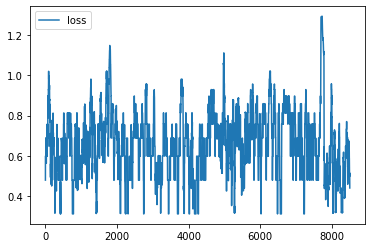

In [24]:
# RNN_cell = RNNCell()
RNN_cell = LSTMCell(mean_val,
                    embedding_size    = EMB_SIZE,
                    hidden_state_size = HID_SIZE,
                    reverse_log_bias  = REVERSE_LOG_BIAS,
                    device=DEVICE)
train_network_RNN (RNN_cell,
                   DEVICE,
                   earthquakes_dataloader_train,
                   n_cycles=N_CYCLES,
                   learning_rate=LEARNING_RATE,
                   earthquake_weight=EARTHQUAKE_WEIGHT,
                   lr_decay=LR_DECAY
                   )

In [25]:
def check_quality (RNN_cell,
                   device,
                   dataloader_test,
                   n_dots=501,
                   info_file=None):
    
    prediction = torch.zeros(dataloader_test.__len__(),  N_CELLS_HOR, N_CELLS_VER,
                             device=device,
                             dtype=torch.float)
    prediction.detach_()
    target     = torch.zeros(dataloader_test.__len__(), N_CELLS_HOR, N_CELLS_VER,
                             device=device,
                             dtype=torch.float)
    target.detach_()
       
    RNN_cell.to(device)

    hid_state = RNN_cell.init_state(batch_size=1, device=device)
    if (type(hid_state) == tuple):
        for elem in hid_state:
            elem.detach_()
    else:
        hid_state.detach_()
        
    i = 0
    for data in tqdm(dataloader_test):

        inputs = data[0].to(device)
        labels = data[1].to(device).float()

        hid_state, outputs = RNN_cell.forward(inputs, hid_state)
        
        prediction[i] = outputs[:, 1, :, :]
        target    [i] = labels.squeeze(0)
    
        if (type(hid_state) == tuple):
            for elem in hid_state:
                elem.detach_()
        else:
            hid_state.detach_()
        prediction.detach_()
        target    .detach_()
        i += 1
        
    assert prediction.shape == target.shape
    prediction = prediction [10:prediction.shape[0]]  # cutting peace of data because
    target     = target     [10:target    .shape[0]]  # hidden state might be not good
    
    print ("ROC_AUC_score = ", end='')
    ROC_AUC_score = roc_auc_score(np.array(target    .view(-1).cpu()),
                                  np.array(prediction.view(-1).cpu()))
    print (ROC_AUC_score)
    if (SAVE_INFO):
        print ('ROC_AUC               =', ROC_AUC_score, file=info_file)
    
    print ("AVG_precision_score = ", end='')
    AVG_precision_score = average_precision_score(np.array(target    .view(-1).cpu()),
                                                  np.array(prediction.view(-1).cpu()))
    print (AVG_precision_score)
    if (SAVE_INFO):
        print ('Average_precision     =', AVG_precision_score, file=info_file)
        
    print ('\n=======================')
    
    for threshold in (0.2, 0.4, 0.6, 0.8):
        print ('Threshold = ', threshold)
        print ('-----------------------')
        print (my_TP_FN_FP_TN(prediction, target, threshold))
        print ('=======================')
    
    if SAVE_INFO:
        print ('\n=======================', file=info_file)
    
        for threshold in (0.2, 0.4, 0.6, 0.8):
            print ('Threshold = ', threshold                    , file=info_file)
            print ('-----------------------'                    , file=info_file)
            print (my_TP_FN_FP_TN(prediction, target, threshold), file=info_file)
            print ('======================='                    , file=info_file)
    
    threshold_massive = torch.linspace (0, 1, n_dots, dtype=torch.float, device=device)
    
#     precision = np.zeros(n_dots)
#     recall    = np.zeros(n_dots)
#     FPR       = np.zeros(n_dots)

    precision_massive = []
    recall_massive    = []
    FPR_massive       = []
    
    for threshold in tqdm(threshold_massive):
        precision, recall, FPR = my_precision_TPR_FPR(prediction, target, threshold)
        precision_massive.append(precision.item())
        recall_massive   .append(recall.item())
        FPR_massive      .append(FPR.item())
    
    # plot 1 precision
    fig = plt.figure(figsize=(10, 6))

    axes = fig.add_axes([0.1, 0.1, 0.8, 0.8])

    axes.plot(np.array(threshold_massive.cpu()), precision_massive, color='green', marker='^')

    axes.set_xlabel('threshold')
    axes.set_ylabel('precision')

    if (SAVE_INFO == True):
        plt.savefig(EXPERIMENT_DIR + 'Precision_from_threshold.png', format='png', dpi=100)
    plt.show()
    
    # plot 2 recall
    fig = plt.figure(figsize=(10, 6))

    axes = fig.add_axes([0.1, 0.1, 0.8, 0.8])

    axes.plot(np.array(threshold_massive.cpu()), recall_massive, color='green', marker='^')

    axes.set_xlabel('threshold')
    axes.set_ylabel('recall')
    
    if (SAVE_INFO == True):
        plt.savefig(EXPERIMENT_DIR + 'Recall_from_threshold.png', format='png', dpi=100)
    plt.show()
    
    # plot 3 ROC-curve
    fig = plt.figure(figsize=(8, 8))

    axes = fig.add_axes([0.1, 0.1, 0.8, 0.8])

    axes.plot(FPR_massive, recall_massive, 'orange', marker = '^')
    axes.plot (range(2), range(2), 'grey', ls='--')

    axes.set_xlabel('FPR')
    axes.set_ylabel('TPR (recall)')
    axes.set_title('ROC-curve')

    if (SAVE_INFO == True):
        plt.savefig(EXPERIMENT_DIR + 'ROC_curve.png', format='png', dpi=100)
    plt.show()
    
    # plot 4 precision-recall-curve
    fig = plt.figure(figsize=(8, 8))

    axes = fig.add_axes([0.1, 0.1, 0.8, 0.8])

    axes.plot(recall_massive, precision_massive, 'orange', marker = '^')

    axes.set_xlabel('Recall')
    axes.set_ylabel('Precision')
    axes.set_title('Precision_Recall_curve')

    if (SAVE_INFO == True):
        plt.savefig(EXPERIMENT_DIR + 'Precision_Recall_curve.png', format='png', dpi=100)
    plt.show()
    
    return ROC_AUC_score, AVG_precision_score

In [26]:
def print_INFO_to_file(info_file):
        
    print ('LEFT_BORDER           =', LEFT_BORDER                           , file=info_file)
    print ('RIGHT_BORDER          =', RIGHT_BORDER                          , file=info_file)
    print ('DOWN_BORDER           =', DOWN_BORDER                           , file=info_file)
    print ('UP_BORDER             =', UP_BORDER                             , file=info_file)
    print ('N_CELLS_HOR           =', N_CELLS_HOR                           , file=info_file)
    print ('N_CELLS_VER           =', N_CELLS_VER                           , file=info_file)
    print (' '                                                              , file=info_file)
    print ('OBSERVED_DAYS         =', OBSERVED_DAYS                         , file=info_file)
    print ('DAYS_TO_PREDICT_AFTER =', DAYS_TO_PREDICT_AFTER                 , file=info_file)
    print ('DAYS_TO_PREDICT_BEFOR =', DAYS_TO_PREDICT_BEFORE                , file=info_file)
    print ('TESTING_DAYS          =', TESTING_DAYS                          , file=info_file)
    print ('HEAVY_QUAKE_THRES     =', HEAVY_QUAKE_THRES                     , file=info_file)
    print ('LEARNING_RATE         =', LEARNING_RATE                         , file=info_file)
    print ('LR_DECAY              =', LR_DECAY                              , file=info_file)
    print ('N_CYCLES              =', N_CYCLES                              , file=info_file)
    print ('EARTHQUAKE_WEIGHT     =', EARTHQUAKE_WEIGHT                     , file=info_file)
    print ('REVERSE_LOG_BIAS      =', REVERSE_LOG_BIAS                      , file=info_file)
    print (' '                                                              , file=info_file)
    print ('TRAIN_SHAPE           =', earthquakes_dataset_train.data.shape  , file=info_file)
    print ('TEST__SHAPE           =', earthquakes_dataset_test .data.shape  , file=info_file)
    print (' '                                                              , file=info_file)
    print ('EMB_SIZE              =', EMB_SIZE                              , file=info_file)
    print ('HID_SIZE              =', HID_SIZE                              , file=info_file)
    
    
#         print ('', , file=info_file)


In [27]:
RNN_cell.eval()

if SAVE_INFO:
    info_file = open (EXPERIMENT_DIR + 'INFO.txt', 'w')
else:
    info_file = None

if SAVE_INFO:
    print_INFO_to_file(info_file)
    
ROC_AUC, AVG_prec = check_quality (RNN_cell,
                                   DEVICE,
                                   earthquakes_dataloader_test,
                                   n_dots=251,
                                   info_file=info_file)

if SAVE_INFO:
    info_file.close()



ROC_AUC_score = 0.9935460871405966
AVG_precision_score = 0.006111383543013812

Threshold =  0.2
-----------------------


RuntimeError: Subtraction, the `-` operator, with a bool tensor is not supported. If you are trying to invert a mask, use the `~` or `logical_not()` operator instead.

In [ ]:
# def train_network_CE (network, 
#                       device,
#                       dataloader_train,
#                       dataloader_test,
#                       epochs=200,
#                       learning_rate=0.1,
#                       earthquake_weight=1.):
    
#     if (SAVE_INFO == True):
#         epochs_file = open (EXPERIMENT_DIR + 'Epochs_info.txt', 'w')
    
#     loss_acc  = []
#     test_acc  = []
#     test_prec = []
#     test_rec  = []
#     net = network.to(device)

#     weights = torch.tensor([1., earthquake_weight], dtype = torch.float).to(device)
#     criterion = nn.CrossEntropyLoss(weights)
    
#     optimizer = torch.optim.SGD(network.parameters(), lr=learning_rate, weight_decay=0.0001, momentum=0.9)

#     for epoch in tqdm(range(epochs)):  # loop over the dataset multiple times
#         if epoch == epochs/2:
#             optimizer = torch.optim.SGD(network.parameters(), lr=learning_rate/10, weight_decay=0.0001, momentum=0.9)
#             print ('Changed learning rate to ', learning_rate/10)
#         elif epoch == epochs*3/4:
#             optimizer = torch.optim.SGD(network.parameters(), lr=learning_rate/100, weight_decay=0.0001, momentum=0.9) 
#             print ('Changed learning rate to ', learning_rate/100)
            
#         net = net.train()        
#         epoch_accuracy = 0.0
#         epoch_elems = 0
#         for data in dataloader_train:
            
#             inputs = data[0].to(device)
#             labels = data[1].to(device)
# #             print ('inputs_shape = ', inputs.shape)
# #             print ('labels_shape = ', labels.shape)

#             # zero the parameter gradients
#             optimizer.zero_grad()

#             # forward + backward + optimize
#             outputs = net(inputs)
# #             print ('outputs : ', outputs.shape, outputs.dtype)
# #             print ('labels  : ', labels.shape , labels.dtype)
# #             outputs = torch.cat ((1-outputs, outputs), dim=1)
# #             print ('outputs ', outputs.shape, '   [', outputs[1, 0, 12, 12], outputs[1, 1, 12, 12], ']')
#             loss = criterion(outputs, labels.squeeze(1).long())
#             loss.backward()
#             optimizer.step()

# #             print (loss)
#             epoch_elems    += labels.shape[0]
#             epoch_accuracy += loss.item()*labels.shape[0]

#         epoch_accuracy /= epoch_elems
#         loss_acc.append(epoch_accuracy)
        
        
# #         calculating test accuracy, precision and recall
#         epoch_accuracy  = 0.0
#         epoch_precision = 0.0
#         epoch_recall    = 0.0
#         epoch_elems = 0
#         for data in dataloader_test:
#             inputs = data[0].to(device)
#             labels = data[1].to(device)   
#             outputs = net(inputs)
# #             find_mistake(outputs)
#             accuracy = my_accuracy (outputs[:, 1, :, :].unsqueeze(1), labels, 0.5)
#             precision, recall = my_precision_recall (outputs[:, 1, :, :].unsqueeze(1), labels, 0.5)
# #             accuracy2 = my_accuracy (outputs, labels, 1.0)
            
#             epoch_elems     += labels.shape[0]
#             epoch_accuracy  += accuracy.item()  * labels.shape[0]
#             epoch_precision += precision.item() * labels.shape[0]
#             epoch_recall    += recall.item()    * labels.shape[0]

# #         epoch_accuracy /= epoch_elems
#         test_acc .append (epoch_accuracy  / epoch_elems)
#         test_prec.append (epoch_precision / epoch_elems)
#         test_rec .append (epoch_recall    / epoch_elems)
        
        
#         print('Ep :', epoch,
#               'loss_tr :' , round (loss_acc [-1], 7),
#               'acc_ts :'  , round (test_acc [-1], 4),
#               'prec_ts :' , round (test_prec[-1], 4),
#               'rec_ts :'  , round (test_rec [-1], 4))
        
#         if (SAVE_INFO == True):
#             print('Ep :', epoch,
#                   'loss_tr :' , round (loss_acc [-1], 7),
#                   'acc_ts :'  , round (test_acc [-1], 4),
#                   'prec_ts :' , round (test_prec[-1], 4),
#                   'rec_ts :'  , round (test_rec [-1], 4)
#                   , file=epochs_file)


#     print('Finished Training')
    
# #     plt.plot(train_acc, label='Train')
#     plt.plot(loss_acc , label='Loss')
#     plt.legend()
#     if (SAVE_INFO == True):
#         plt.savefig(EXPERIMENT_DIR + 'Loss_train.png', format='png', dpi=100)
#     plt.show()
    
#     plt.plot(test_acc , label='Test Accuracy')
#     plt.legend()
#     if (SAVE_INFO == True):
#         plt.savefig(EXPERIMENT_DIR + 'Accuracy_test.png', format='png', dpi=100)
#     plt.show()
    
#     plt.plot(test_prec, label='Test Precision')
#     plt.legend()
#     if (SAVE_INFO == True):
#         plt.savefig(EXPERIMENT_DIR + 'Precision_test.png', format='png', dpi=100)
#     plt.show()
    
#     plt.plot(test_rec , label='Test Recall')
#     plt.legend()
#     if (SAVE_INFO == True):
#         plt.savefig(EXPERIMENT_DIR + 'Recall_test.png', format='png', dpi=100)
#     plt.show()
    
#     if (SAVE_INFO == True):
#         epochs_file.close()

In [ ]:
# LEARNING_RATE = 0.1
# N_EPOCHS = 200
# EARTHQUAKE_WEIGHT = 10000.

# earthquake_network = ConvNetwork_CE ()
# train_network_CE  (earthquake_network,
#                    torch.device(DEVICE),
#                    earthquakes_dataloader_train,
#                    earthquakes_dataloader_test,
#                    epochs=N_EPOCHS,
#                    learning_rate=LEARNING_RATE,
#                    earthquake_weight=EARTHQUAKE_WEIGHT
#                    )

In [ ]:
# def print_ROCinfo (model, dataLoader, device, alpha=0.5, n_dots=101):
#     model = model.to(device)
    
    
#     threshold_massive = np.linspace (0, n_dots-1, n_dots, dtype=int)
#     TP_massive = np.zeros (n_dots)
#     FP_massive = np.zeros (n_dots)
#     FN_massive = np.zeros (n_dots)
#     TN_massive = np.zeros (n_dots)
    
#     for data in dataLoader:
#         inputs = data[0].to(device)
#         labels = data[1].to(device)

#         outputs = model(inputs)
        
#         for threshold in threshold_massive:
#             prediction = (outputs[:, 1, :, :].unsqueeze(1))>(threshold/n_dots)
#             TP_massive[threshold] += torch.sum (prediction       * labels      ).float()
#             FP_massive[threshold] += torch.sum (prediction       * (1 - labels)).float()
#             FN_massive[threshold] += torch.sum ((1 - prediction) * labels      ).float()
#             TN_massive[threshold] += torch.sum ((1 - prediction) * (1 - labels)).float()
            
#     threshold_massive = threshold_massive / (n_dots-1)
#     precision_massive = TP_massive / (TP_massive + FP_massive)
#     TPR_massive       = TP_massive / (TP_massive + FN_massive)
#     FPR_massive       = FP_massive / (FP_massive + TN_massive)

#     sum_events = TP_massive[int(len(TP_massive)/2)] + FP_massive[int(len(FP_massive)/2)] + FN_massive[int(len(FN_massive)/2)] + TN_massive[int(len(TN_massive)/2)] 
#     print ('TP = ', round(TP_massive[int(len(TP_massive)/2)] / sum_events, 6), '%')
#     print ('FP = ', round(FP_massive[int(len(FP_massive)/2)] / sum_events, 6), '%')
#     print ('FN = ', round(FN_massive[int(len(FN_massive)/2)] / sum_events, 6), '%')
#     print ('TN = ', round(TN_massive[int(len(TN_massive)/2)] / sum_events, 6), '%')
    
#     if (SAVE_INFO == True):
#         print ('TP = ', round(TP_massive[int(len(TP_massive)/2)] / sum_events, 6), '%', file=INFO_FILE)
#         print ('FP = ', round(FP_massive[int(len(FP_massive)/2)] / sum_events, 6), '%', file=INFO_FILE)
#         print ('FN = ', round(FN_massive[int(len(FN_massive)/2)] / sum_events, 6), '%', file=INFO_FILE)
#         print ('TN = ', round(TN_massive[int(len(TN_massive)/2)] / sum_events, 6), '%', file=INFO_FILE)
    
#     # plot 1 precision
#     fig1 = plt.figure(figsize=(10, 6))

#     axes = fig1.add_axes([0.1, 0.1, 0.8, 0.8])

#     axes.plot(threshold_massive, precision_massive, color='green', marker='^')

#     axes.set_xlabel('threshold')
#     axes.set_ylabel('precision')

#     if (SAVE_INFO == True):
#         plt.savefig(EXPERIMENT_DIR + 'Precision_from_threshold.png', format='png', dpi=100)
#     plt.show()
    
#     # plot 2 recall
#     fig = plt.figure(figsize=(10, 6))

#     axes = fig.add_axes([0.1, 0.1, 0.8, 0.8])

#     axes.plot(threshold_massive, TPR_massive, color='green', marker='^')

#     axes.set_xlabel('threshold')
#     axes.set_ylabel('recall')
    
#     if (SAVE_INFO == True):
#         plt.savefig(EXPERIMENT_DIR + 'Recall_from_threshold.png', format='png', dpi=100)
#     plt.show()
    
#     # plot 3 ROC-curve
#     fig = plt.figure(figsize=(8, 8))

#     axes = fig.add_axes([0.1, 0.1, 0.8, 0.8])

#     axes.plot(FPR_massive, TPR_massive, 'orange', marker = '^')
#     axes.plot (range(2), range(2), 'grey', ls='--')

#     axes.set_xlabel('FPR')
#     axes.set_ylabel('TPR (recall)')
#     axes.set_title('ROC-curve')

#     if (SAVE_INFO == True):
#         plt.savefig(EXPERIMENT_DIR + 'ROC_curve.png', format='png', dpi=100)
#     plt.show()
    
#     del model
#     del inputs
#     del labels

In [ ]:
# class ConvNetwork_MSE (nn.Module):
    
#     def __init__(self):
#         super(ConvNetwork_CE, self).__init__()
        
#         self.features = nn.Sequential()
        
#         self.features.add_module('conv1', conv_block(     OBSERVED_DAYS    , int (OBSERVED_DAYS/2 ), 3))
#         self.features.add_module('conv2', conv_block(int (OBSERVED_DAYS/2 ), int (OBSERVED_DAYS/4 ), 3))
#         self.features.add_module('conv3', conv_block(int (OBSERVED_DAYS/4 ), int (OBSERVED_DAYS/8 ), 3))
#         self.features.add_module('conv4', conv_block(int (OBSERVED_DAYS/8 ), int (OBSERVED_DAYS/16), 3))
#         self.features.add_module('conv5', conv_block(int (OBSERVED_DAYS/16),                      1, 3))
        
#         # might be a good idea to add an extra full connected layer
        
#     def forward(self, x):
# #         print ('input  : ', x.shape)
#         x = self.features(x)
# #         print ('output : ', x.shape)
#         return x
        

In [ ]:
# def train_network_MSE(network, 
#                       device,
#                       dataloader_train,
#                       dataloader_test,
#                       epochs=164,
#                       learning_rate=0.1):
    
#     train_acc = []
#     test_acc  = []
#     net = network.to(device)

#     criterion = nn.MSELoss()
#     optimizer = torch.optim.SGD(network.parameters(), lr=learning_rate, weight_decay=0.0001, momentum=0.9)

    
#     for epoch in tqdm(range(epochs)):  # loop over the dataset multiple times
#         if epoch == epochs/2:
#             optimizer = torch.optim.SGD(network.parameters(), lr=learning_rate/10, weight_decay=0.0001, momentum=0.9) 
#         elif epoch == epochs*3/4:
#             optimizer = torch.optim.SGD(network.parameters(), lr=learning_rate/100, weight_decay=0.0001, momentum=0.9) 
        
#         net = net.train()        
#         epoch_accuracy = 0.0
#         epoch_elems = 0
#         for data in dataloader_train:
            
#             inputs = data[0].to(device)
#             labels = data[1].to(device)
# #             print ('inputs_shape = ', inputs.shape)
# #             print ('labels_shape = ', labels.shape)

#             # zero the parameter gradients
#             optimizer.zero_grad()

#             # forward + backward + optimize
#             outputs = net(inputs)
# #             print ('outputs : ', outputs.dtype)
# #             print ('labels  : ', labels.dtype)
#             loss = criterion(outputs, labels)
#             loss.backward()
#             optimizer.step()

# #             print (loss)
#             epoch_elems    += labels.shape[0]
#             epoch_accuracy += loss.item()*labels.shape[0]

#         epoch_accuracy /= epoch_elems
#         train_acc.append(epoch_accuracy)
        
        
#         # calculating test accuracy
#         epoch_accuracy = 0.0
#         epoch_elems = 0
#         for data in dataloader_test:
#             inputs = data[0].to(device)
#             labels = data[1].to(device)   
#             outputs = net(inputs)
#             loss = criterion(outputs, labels)
            
#             epoch_elems    += labels.shape[0]
#             epoch_accuracy += loss.item()*labels.shape[0]

#         epoch_accuracy /= epoch_elems
#         test_acc.append(epoch_accuracy)
        
        
#         print('Epoch : ', epoch, 'acc_train : ', round (train_acc[-1], 4), 'acc_test : ', round (test_acc[-1], 4))

#     print('Finished Training')
    
#     plt.plot(train_acc, label='Train')
#     plt.plot(test_acc , label='Test' )
#     plt.legend()
#     plt.grid()

In [ ]:
# earthquake_netowrk = ConvNetwork_MSE ()
# train_network_MSE (earthquake_netowrk,
#                    torch.device(DEVICE),
#                    earthquakes_dataloader_train,
#                    earthquakes_dataloader_test,
#                    epochs=200,
#                    )

In [ ]:
# def find_mistake (x):
#     assert (torch.sum((x < 0.0) + (x > 1.0)) == 0)

In [ ]:
# loss = nn.CrossEntropyLoss()
# input = torch.randn(3, 5, requires_grad=True)
# target = torch.empty(3, dtype=torch.long).random_(5)
# print ('input  : ', input.shape, input.dtype)
# print (input)
# print (torch.sum (input, dim = 0))
# print ('target : ', target.shape, target.dtype)
# print (target)
# output = loss(input, target)
# output.backward()

In [ ]:
# import torch
# from torch.utils.data import Dataset, DataLoader

# class someDataset (Dataset):
#     def __init__(self):
#         self.data = torch.ones ([100, 32, 10, 10])
#         self.labels = torch.ones ([100, 1, 10, 10])
#         self.len  = self.data.shape[0]
        
#         print (self.data.shape)
#         print (self.labels.shape)
        
#     def __len__ (self):
#         return self.len
    
#     def __getitem__(self, idx):
#         print ('data_shape = ', self.data[idx].shape)
#         print ('result_shape = ', self.labels[idx].shape)
#         return self.data[idx], self.labels[idx]

In [ ]:
# some_dataset = someDataset()
# dataloader = DataLoader (some_dataset,
#                          batch_size=32,
#                          shuffle=True,
#                          num_workers=1,
#                          )

# for i, batch in enumerate(dataloader, 0):
#     data = batch[0]
#     print (i, 'data ', data.shape)
#     labels = batch[1]
#     print (i, 'labels ', labels.shape)
    


# # eartquakes_dataloader_train = DataLoader(earthquakes_dataset_train,
# #                                          batch_size=33,
# #                                          shuffle=True,
# #                                          num_workers=4)
